# TODO
- Comments
- Show dates instead of numbers on x-axis

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet

In [38]:
data = pd.read_csv("incoming_packages.csv")

In [39]:
# Convert string dates into datetime objects
data_final = data.copy()
data_final['date'] = pd.to_datetime(data_final['date'])

In [40]:
def get_prophet_data( col:str, startdate:datetime, enddate:datetime ) -> pd.DataFrame:
    """ Get data that can be used by prophet from the specified date range. """
    prophet_data = pd.DataFrame()
    prophet_data["ds"] = data_final["date"]
    prophet_data["y"] = data_final[col]
    prophet_data = prophet_data[ (prophet_data['ds'] >= startdate) & (prophet_data['ds'] <= enddate)]

    return prophet_data

In [41]:
data.head(len(data))

,date,total_packages,cooled_packages,fire_packages,normal_packages
0,2020-01-01,1745,370,488,887
1,2020-01-02,1847,308,402,1137
2,2020-01-03,1842,314,394,1134
3,2020-01-04,664,131,181,352
4,2020-01-05,871,137,190,544
...,...,...,...,...,...
846,2022-04-26,2268,467,503,1298
847,2022-04-27,2466,432,641,1393
848,2022-04-28,2436,545,556,1335
849,2022-04-29,2302,368,547,1387


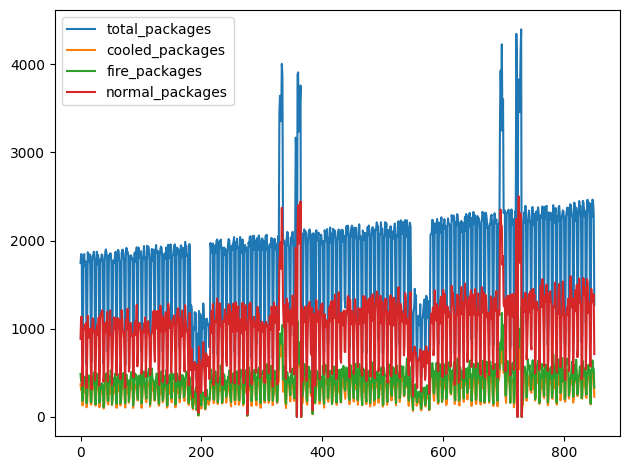

In [42]:
data.plot()

plt.tight_layout()
plt.show()

In [43]:
total_packages_train = get_prophet_data("total_packages", datetime(2020, 1, 1), datetime(2022, 4, 21))
total_packages_train.head(len(total_packages_train))

,ds,y
0,2020-01-01,1745
1,2020-01-02,1847
2,2020-01-03,1842
3,2020-01-04,664
4,2020-01-05,871
...,...,...
837,2022-04-17,1339
838,2022-04-18,2458
839,2022-04-19,2464
840,2022-04-20,2329


In [44]:
# Train prophet
prophet_ = Prophet()
prophet_.fit(total_packages_train)

13:22:00 - cmdstanpy - INFO - Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# Test prophet
total_packages_test = get_prophet_data("total_packages", datetime(2022, 4, 21), datetime(2022, 4, 30))
prophet_.predict()
plt.show()